In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from numpy import inf
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
from scipy import stats
import matplotlib.pyplot as plt
import tropycal
from tropycal import tracks
from shapely.geometry import Polygon, Point


In [14]:
meta = pd.read_csv(f'/user/home/al18709/work/ke_track_inputs/mri6_hist_tracks.csv')
meta.lon[meta.lon > 180] = meta.lon[meta.lon >180] - 360
meta2 = pd.DataFrame({'sid':meta.sid ,'centre_lat':meta.lat, 'centre_lon':meta.lon, 'hour':meta.hour, 'day':meta.day,'month':meta.month, 'year':meta.year})
# rain = data[meta2.year >= 2085]
meta3 = meta2[meta2.year >= 2085].reset_index()
meta4 = pd.DataFrame({'sid':meta3.sid ,'centre_lat':meta3.centre_lat, 'centre_lon':meta3.centre_lon})


/tmp/ipykernel_270796/2006317347.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meta.lon[meta.lon > 180] = meta.lon[meta.lon >180] - 360


In [16]:
meta4

,sid,centre_lat,centre_lon


In [15]:
sids = meta4.sid
sids_unique=sids.drop_duplicates()
tracks_grouped = meta.groupby('sid')
print(sids_unique)
for sid in sids_unique:
	storm = tracks_grouped.get_group(sid)

Series([], Name: sid, dtype: object)


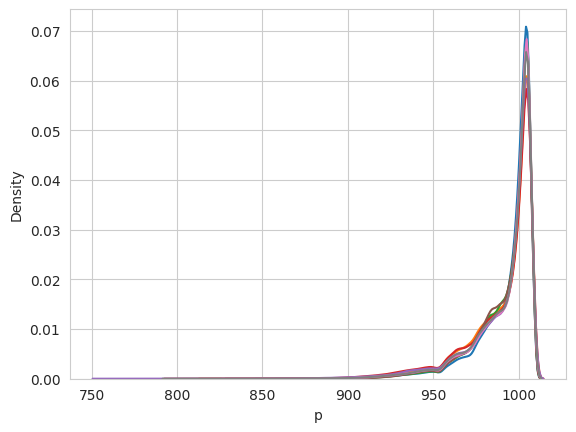

In [67]:
models = ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']
for model in models:
    data = pd.read_csv(f'/user/home/al18709/work/ke_track_inputs/{model}_hist_tracks.csv')
    x = list(range(len(data.p)))
    y = data.p
    sns.kdeplot(y)
# plt.yscale('log')
plt.show()

# plot this by basin

In [68]:
for model in ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']:
	for scenario in ['hist','ssp245','ssp585']:
		# globals()[f'{model}_topography_{scenario}'] = np.load(f'/user/home/al18709/work/ke_track_inputs/{model}_{scenario}_topography.npy')
		# print(model,scenario)
		data = pd.read_csv(f'/user/home/al18709/work/ke_track_inputs/{model}_{scenario}_tracks.csv')
		data['p'] = data['p'] * 100
		data.lon[data.lon > 180] = data.lon[data.lon >180] - 360
		globals()[f'{model}_tracks_{scenario}'] = data

/tmp/ipykernel_268828/2882623355.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.lon[data.lon > 180] = data.lon[data.lon >180] - 360
/tmp/ipykernel_268828/2882623355.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.lon[data.lon > 180] = data.lon[data.lon >180] - 360
/tmp/ipykernel_268828/2882623355.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.lon[data.lon > 180] = data.lon[data.lon >180] - 360
/tmp/ipykerne

In [69]:
# for model in ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']:
#     globals()[f'{model}_tracks_hist'] = 
from cmethods import CMethods as cm
# from cmethods import adjust
# from cmethods.distribution import detrended_quantile_mapping
# quantile_mapping = cm.CMethods.quantile_mapping
quantile_mapping = cm.quantile_mapping
import random

training_inputs = np.load('/user/work/al18709/tc_data_flipped/KE_tracks/train_X.npy')


ensemble = pd.concat([canesm_tracks_hist,cnrm6_tracks_hist,ipsl6_tracks_hist,miroc6_tracks_hist,mpi6_tracks_hist,mri6_tracks_hist,ukmo_tracks_hist])
print(ensemble.shape)

(2507609, 13)


In [70]:

print(data.p.shape)
idx = random.choices(range(2507609),k=45623)
# print(idx)

(501378,)


In [71]:
ensemble.p.iloc[idx]

142914    100616.0
121137    100532.0
100396     96776.0
271858     99718.0
309077    100818.0
            ...   
288004     99988.0
319633    100194.0
264151     97678.0
140650    100642.0
97163      99762.0
Name: p, Length: 45623, dtype: float64

In [72]:
training_inputs[:,0]

array([100368.38820312, 100589.27945312, 100588.41671875, ...,
       101202.35273438, 101254.86      , 101302.53890625])

In [73]:
np.array(list(ensemble.p.iloc[idx]))

array([100616., 100532.,  96776., ...,  97678., 100642.,  99762.])

In [74]:
models = ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']
for model in models:
    data = pd.read_csv(f'/user/home/al18709/work/ke_track_inputs/{model}_hist_tracks.csv')
    n_quantiles = 400
    obs = xr.Dataset({'var':training_inputs[:,0]})
    simh = xr.Dataset({'var':np.array(list(ensemble.p.iloc[idx]))})
    simp = xr.Dataset({'var':np.array(list(data.p * 100))}) # distribution to bias correct
    mslp_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)

    obs = xr.Dataset({'var':training_inputs[:,1]})
    simh = xr.Dataset({'var':ensemble.u850.iloc[idx]})
    simp = xr.Dataset({'var':data.u850}) # distribution to bias correct
    u850_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)

    obs = xr.Dataset({'var':training_inputs[:,2]})
    simh = xr.Dataset({'var':ensemble.v850.iloc[idx]})
    simp = xr.Dataset({'var':data.v850}) # distribution to bias correct
    v850_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)

    obs = xr.Dataset({'var':training_inputs[:,3]})
    simh = xr.Dataset({'var':ensemble.shear.iloc[idx]})
    simp = xr.Dataset({'var':data.shear}) # distribution to bias correct
    shear_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)

    obs = xr.Dataset({'var':training_inputs[:,4]})
    simh = xr.Dataset({'var':ensemble.lat.iloc[idx]})
    simp = xr.Dataset({'var':data.lat}) # distribution to bias correct
    lat_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)

    obs = xr.Dataset({'var':training_inputs[:,5]})
    simh = xr.Dataset({'var':ensemble.lon.iloc[idx]})
    data.lon[data.lon > 180] = data.lon[data.lon >180] - 360
    simp = xr.Dataset({'var':data.lon}) # distribution to bias correct
    lon_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)


    # globals()[f'{model}_hist_corrected'] = np.stack((mslp_qm.values,u850_qm.values,v850_qm.values,shear_qm.values,lat_qm.values,lon_qm.values),axis=-1)
    globals()[f'{model}_hist_corrected'] = np.stack((mslp_qm,u850_qm,v850_qm,shear_qm,data.lat,data.lon),axis=-1)
    # # print(bias_corrected_data)
    np.save(f'/user/home/al18709/work/ke_track_inputs/{model}_hist_qm.npy',globals()[f'{model}_hist_corrected'])


/tmp/ipykernel_268828/3323090658.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.lon[data.lon > 180] = data.lon[data.lon >180] - 360
/tmp/ipykernel_268828/3323090658.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.lon[data.lon > 180] = data.lon[data.lon >180] - 360
/tmp/ipykernel_268828/3323090658.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.lon[data.lon > 180] = data.lon[data.lon >180] - 360
/tmp/ipyke

(348233, 6)
(348233, 13)
[101724.5057574  101752.03459352 101717.96409073 ... 101160.54260427
 101177.89797617 101196.03931021]
(348233, 6)


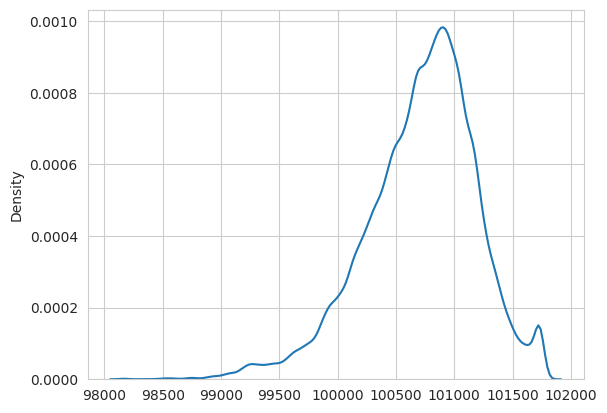

In [75]:
print(ipsl6_hist_corrected.shape)
print(ipsl6_tracks_hist.shape)
print(mslp_qm)
sns.kdeplot(mslp_qm)
print(ipsl6_hist_corrected.shape)
# sns.kdeplot(ipsl6_hist_corrected[:,5])
# sns.kdeplot(lon_qm)

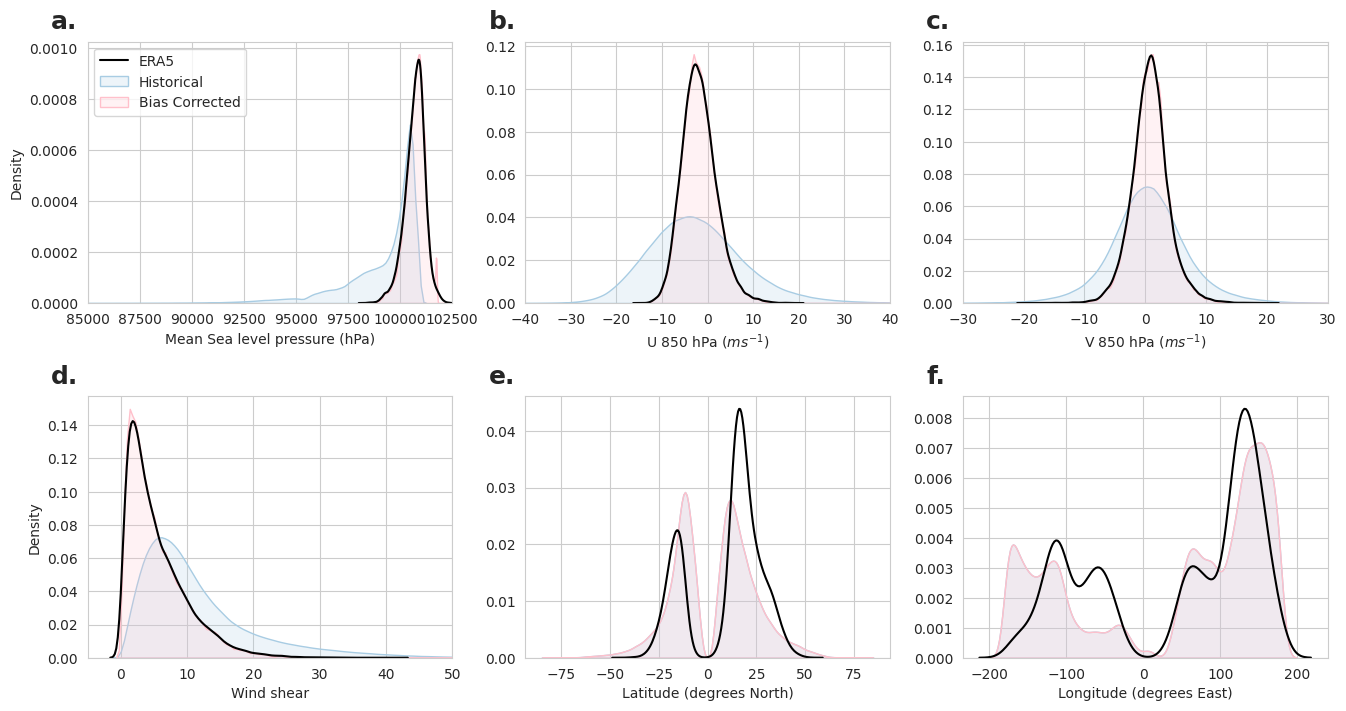

In [76]:
sns.set_style("whitegrid")  # You can change the style to your preference
height_ratios = [1,0.08,1]
fig, axes = plt.subplots(3, 3, figsize=(16, 8),gridspec_kw={'height_ratios': height_ratios})
titles = ['Mean Sea level pressure (hPa)', 'U 850 hPa ($ms^{-1}$)', 'V 850 hPa ($ms^{-1}$)', 'Wind shear', 'Latitude (degrees North)', 'Longitude (degrees East)']
labels = ['a.','b.','c.','d.','e.','f.']
columns = ['p','u850','v850','shear','lat','lon']
for i in range(6):
    row, col = divmod(i, 3)
    
    if row == 1:
        # axes[row,col].set_facecolor('white')
        # axes[row,col] = 'off'
        axes[row,col].set_axis_off()
        row = 2

    sns.kdeplot(training_inputs[:,i].flatten(),fill=False, color="Black", ax=axes[row,col])
    # sns.kdeplot(np.concatenate((ipsl6_tracks_ssp585[columns[i]],canesm_tracks_ssp585[columns[i]],cnrm6_tracks_ssp585[columns[i]],ecearth6_tracks_ssp585[columns[i]],miroc6_tracks_ssp585[columns[i]],mpi6_tracks_ssp585[columns[i]],mri6_tracks_ssp585[columns[i]])), fill=True,alpha=0.05 ,color="Red", ax=axes[row,col])
    # sns.kdeplot(np.concatenate((ipsl6_tracks_ssp245[columns[i]],canesm_tracks_ssp245[columns[i]],cnrm6_tracks_ssp245[columns[i]],ecearth6_tracks_ssp245[columns[i]],miroc6_tracks_ssp245[columns[i]],mpi6_tracks_ssp245[columns[i]],mri6_tracks_ssp245[columns[i]])), fill=True,alpha=0.05 ,color="Orange", ax=axes[row,col])

    sns.kdeplot(np.concatenate((ipsl6_tracks_hist[columns[i]],canesm_tracks_hist[columns[i]],cnrm6_tracks_hist[columns[i]],ecearth6_tracks_hist[columns[i]],miroc6_tracks_hist[columns[i]],mpi6_tracks_hist[columns[i]],mri6_tracks_hist[columns[i]])), fill=True,alpha=0.2, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(np.concatenate((ipsl6_hist_corrected[:,i].flatten(),canesm_hist_corrected[:,i].flatten(),cnrm6_hist_corrected[:,i].flatten(),ecearth6_hist_corrected[:,i].flatten(),miroc6_hist_corrected[:,i].flatten(),mpi6_hist_corrected[:,i].flatten(),mri6_hist_corrected[:,i].flatten())), fill=True,alpha=0.2, color="Pink", ax=axes[row,col])
    

    
    axes[row,col].text(-0.1, 1.05, labels[i], transform=axes[row,col].transAxes, size=18, weight='bold')
    # axes[row,col].set_title(titles[i])
    axes[row,col].set_xlabel(titles[i])
    axes[row,col].set_ylabel("")
    
axes[0,0].set_ylabel('Density')
axes[2,0].set_ylabel('Density')
axes[0,0].set_xlim(85000,102500)
axes[0,1].set_xlim(-40,40)
axes[0,2].set_xlim(-30,30)
axes[2,0].set_xlim(-5,50)
# plt.title("Kernel Density Estimation (KDE) Plot")
# plt.xlabel("Values")
# plt.ylabel("Density")
# plt.show()
axes[0,0].legend(['ERA5','Historical','Bias Corrected'])
plt.savefig('bias_correction.png',bbox_inches='tight',dpi=600)

# Reminder that this is based on ERA5 input data, so not necessarily 100% accurate. ERA5 is easy to work with but is 
# still a reanalysis product and therefore will still have some bias especially with U and V

In [77]:
models = ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']
for model in models:
    data = pd.read_csv(f'/user/home/al18709/work/ke_track_inputs/{model}_ssp585_tracks.csv')
    n_quantiles = 400
    obs = xr.Dataset({'var':training_inputs[:,0]})
    simh = xr.Dataset({'var':np.array(list(ensemble.p.iloc[idx]))})
    simp = xr.Dataset({'var':np.array(list(data.p * 100))}) # distribution to bias correct
    mslp_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)

    obs = xr.Dataset({'var':training_inputs[:,1]})
    simh = xr.Dataset({'var':ensemble.u850.iloc[idx]})
    simp = xr.Dataset({'var':data.u850}) # distribution to bias correct
    u850_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)

    obs = xr.Dataset({'var':training_inputs[:,2]})
    simh = xr.Dataset({'var':ensemble.v850.iloc[idx]})
    simp = xr.Dataset({'var':data.v850}) # distribution to bias correct
    v850_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)

    obs = xr.Dataset({'var':training_inputs[:,3]})
    simh = xr.Dataset({'var':ensemble.shear.iloc[idx]})
    simp = xr.Dataset({'var':data.shear}) # distribution to bias correct
    shear_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)

    obs = xr.Dataset({'var':training_inputs[:,4]})
    simh = xr.Dataset({'var':ensemble.lat.iloc[idx]})
    simp = xr.Dataset({'var':data.lat}) # distribution to bias correct
    lat_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)

    obs = xr.Dataset({'var':training_inputs[:,5]})
    simh = xr.Dataset({'var':ensemble.lon.iloc[idx]})
    data.lon[data.lon > 180] = data.lon[data.lon >180] - 360
    simp = xr.Dataset({'var':data.lon}) # distribution to bias correct
    lon_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)


    # globals()[f'{model}_hist_corrected'] = np.stack((mslp_qm.values,u850_qm.values,v850_qm.values,shear_qm.values,lat_qm.values,lon_qm.values),axis=-1)
    globals()[f'{model}_ssp585_corrected'] = np.stack((mslp_qm,u850_qm,v850_qm,shear_qm,data.lat,data.lon),axis=-1)
    # # print(bias_corrected_data)
    # # np.save('',bias_corrected_data)
    np.save(f'/user/home/al18709/work/ke_track_inputs/{model}_ssp585_qm.npy',globals()[f'{model}_ssp585_corrected'])


/tmp/ipykernel_268828/3855388061.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.lon[data.lon > 180] = data.lon[data.lon >180] - 360
/tmp/ipykernel_268828/3855388061.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.lon[data.lon > 180] = data.lon[data.lon >180] - 360
/tmp/ipykernel_268828/3855388061.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.lon[data.lon > 180] = data.lon[data.lon >180] - 360
/tmp/ipyke

In [78]:
models = ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']
for model in models:
    data = pd.read_csv(f'/user/home/al18709/work/ke_track_inputs/{model}_ssp245_tracks.csv')
    n_quantiles = 400
    obs = xr.Dataset({'var':training_inputs[:,0]})
    simh = xr.Dataset({'var':np.array(list(ensemble.p.iloc[idx]))})
    simp = xr.Dataset({'var':np.array(list(data.p * 100))}) # distribution to bias correct
    mslp_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)

    obs = xr.Dataset({'var':training_inputs[:,1]})
    simh = xr.Dataset({'var':ensemble.u850.iloc[idx]})
    simp = xr.Dataset({'var':data.u850}) # distribution to bias correct
    u850_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)

    obs = xr.Dataset({'var':training_inputs[:,2]})
    simh = xr.Dataset({'var':ensemble.v850.iloc[idx]})
    simp = xr.Dataset({'var':data.v850}) # distribution to bias correct
    v850_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)

    obs = xr.Dataset({'var':training_inputs[:,3]})
    simh = xr.Dataset({'var':ensemble.shear.iloc[idx]})
    simp = xr.Dataset({'var':data.shear}) # distribution to bias correct
    shear_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)

    obs = xr.Dataset({'var':training_inputs[:,4]})
    simh = xr.Dataset({'var':ensemble.lat.iloc[idx]})
    simp = xr.Dataset({'var':data.lat}) # distribution to bias correct
    lat_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)

    obs = xr.Dataset({'var':training_inputs[:,5]})
    simh = xr.Dataset({'var':ensemble.lon.iloc[idx]})
    data.lon[data.lon > 180] = data.lon[data.lon >180] - 360
    simp = xr.Dataset({'var':data.lon}) # distribution to bias correct
    lon_qm = quantile_mapping(obs=obs["var"],simh=simh["var"],simp=simp["var"],n_quantiles=n_quantiles)


    # globals()[f'{model}_hist_corrected'] = np.stack((mslp_qm.values,u850_qm.values,v850_qm.values,shear_qm.values,lat_qm.values,lon_qm.values),axis=-1)
    globals()[f'{model}_ssp245_corrected'] = np.stack((mslp_qm,u850_qm,v850_qm,shear_qm,data.lat,data.lon),axis=-1)
    # # print(bias_corrected_data)
    # # np.save('',bias_corrected_data)
    np.save(f'/user/home/al18709/work/ke_track_inputs/{model}_ssp245_qm.npy',globals()[f'{model}_ssp245_corrected'])


/tmp/ipykernel_268828/1629636655.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.lon[data.lon > 180] = data.lon[data.lon >180] - 360
/tmp/ipykernel_268828/1629636655.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.lon[data.lon > 180] = data.lon[data.lon >180] - 360
/tmp/ipykernel_268828/1629636655.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.lon[data.lon > 180] = data.lon[data.lon >180] - 360
/tmp/ipyke

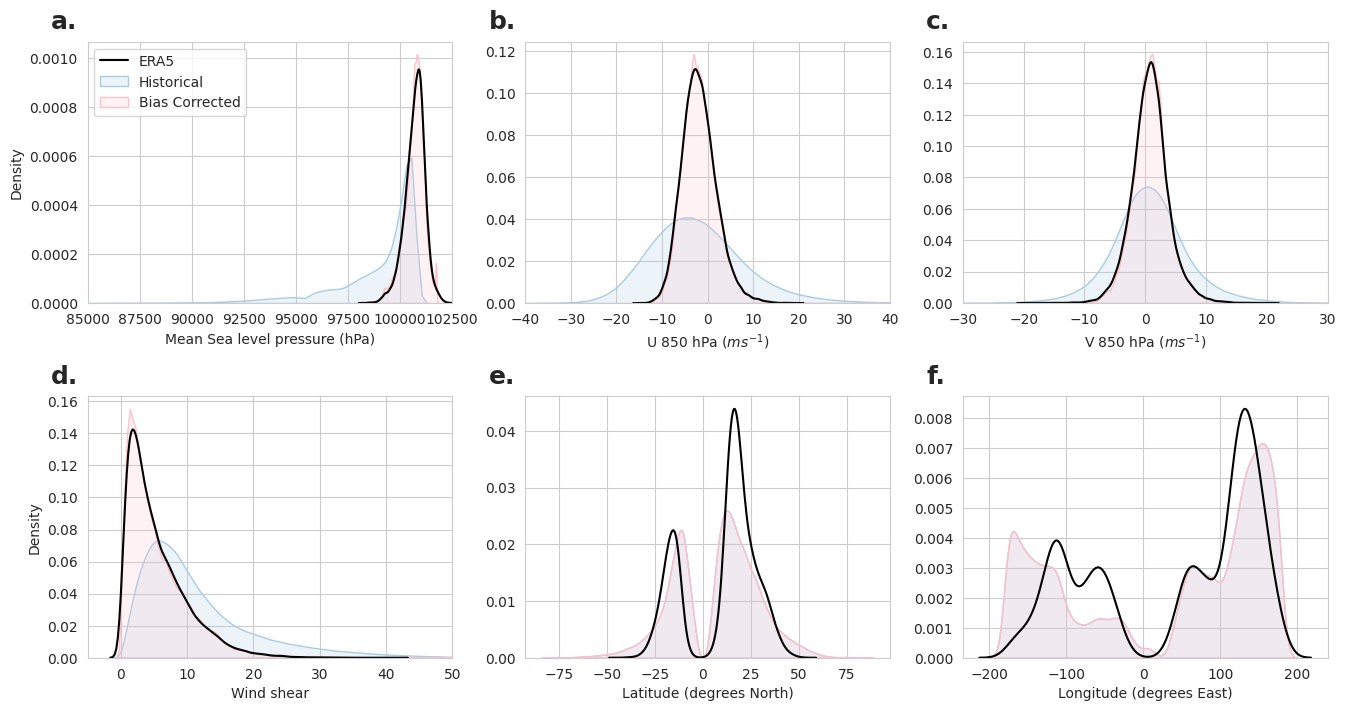

In [79]:
sns.set_style("whitegrid")  # You can change the style to your preference
height_ratios = [1,0.08,1]
fig, axes = plt.subplots(3, 3, figsize=(16, 8),gridspec_kw={'height_ratios': height_ratios})
titles = ['Mean Sea level pressure (hPa)', 'U 850 hPa ($ms^{-1}$)', 'V 850 hPa ($ms^{-1}$)', 'Wind shear', 'Latitude (degrees North)', 'Longitude (degrees East)']
labels = ['a.','b.','c.','d.','e.','f.']
columns = ['p','u850','v850','shear','lat','lon']
for i in range(6):
    row, col = divmod(i, 3)
    
    if row == 1:
        # axes[row,col].set_facecolor('white')
        # axes[row,col] = 'off'
        axes[row,col].set_axis_off()
        row = 2

    sns.kdeplot(training_inputs[:,i].flatten(),fill=False, color="Black", ax=axes[row,col])
    # sns.kdeplot(np.concatenate((ipsl6_tracks_ssp585[columns[i]],canesm_tracks_ssp585[columns[i]],cnrm6_tracks_ssp585[columns[i]],ecearth6_tracks_ssp585[columns[i]],miroc6_tracks_ssp585[columns[i]],mpi6_tracks_ssp585[columns[i]],mri6_tracks_ssp585[columns[i]])), fill=True,alpha=0.05 ,color="Red", ax=axes[row,col])
    # sns.kdeplot(np.concatenate((ipsl6_tracks_ssp245[columns[i]],canesm_tracks_ssp245[columns[i]],cnrm6_tracks_ssp245[columns[i]],ecearth6_tracks_ssp245[columns[i]],miroc6_tracks_ssp245[columns[i]],mpi6_tracks_ssp245[columns[i]],mri6_tracks_ssp245[columns[i]])), fill=True,alpha=0.05 ,color="Orange", ax=axes[row,col])

    sns.kdeplot(np.concatenate((ipsl6_tracks_ssp585[columns[i]],canesm_tracks_ssp585[columns[i]],cnrm6_tracks_ssp585[columns[i]],ecearth6_tracks_ssp585[columns[i]],miroc6_tracks_ssp585[columns[i]],mpi6_tracks_ssp585[columns[i]],mri6_tracks_ssp585[columns[i]])), fill=True,alpha=0.2, color="#A8CCE3", ax=axes[row,col])
    sns.kdeplot(np.concatenate((ipsl6_ssp585_corrected[:,i].flatten(),canesm_ssp585_corrected[:,i].flatten(),cnrm6_ssp585_corrected[:,i].flatten(),ecearth6_ssp585_corrected[:,i].flatten(),miroc6_ssp585_corrected[:,i].flatten(),mpi6_ssp585_corrected[:,i].flatten(),mri6_ssp585_corrected[:,i].flatten())), fill=True,alpha=0.2, color="Pink", ax=axes[row,col])
    
    
    
    axes[row,col].text(-0.1, 1.05, labels[i], transform=axes[row,col].transAxes, size=18, weight='bold')
    # axes[row,col].set_title(titles[i])
    axes[row,col].set_xlabel(titles[i])
    axes[row,col].set_ylabel("")
    
axes[0,0].set_ylabel('Density')
axes[2,0].set_ylabel('Density')
axes[0,0].set_xlim(85000,102500)
axes[0,1].set_xlim(-40,40)
axes[0,2].set_xlim(-30,30)
axes[2,0].set_xlim(-5,50)
# plt.title("Kernel Density Estimation (KDE) Plot")
# plt.xlabel("Values")
# plt.ylabel("Density")
# plt.show()
axes[0,0].legend(['ERA5','Historical','Bias Corrected'])
plt.savefig('bias_correction_ssp585.png',bbox_inches='tight',dpi=600)

# Reminder that this is based on ERA5 input data, so not necessarily 100% accurate. ERA5 is easy to work with but is 
# still a reanalysis product and therefore will still have some bias especially with U and V

In [ ]:
# use quantile mapping to bias correct these fields.
# from cmethods import CMethods as cm

# obs = pd.DataFrame({'var' : X_train[:,0]}) # og distribution
# simh = pd.DataFrame({'var' : X_miroc[:,0][:45623]}) # modelled distribution
# simp =  pd.DataFrame({'var' : X_miroc[:,0]}) # distribution to bias correct
# variable = "var" # temperatures


# mslp_qm = cm.quantile_mapping(obs=obs[variable],simh=simh[variable],simp=simp[variable],n_quantiles=250)

# u850_qm = cm.quantile_mapping(obs=pd.DataFrame({'var' : X_train[:,1]})['var'],simh=pd.DataFrame({'var' : X_miroc[:,1]})[:45623]['var'],simp=pd.DataFrame({'var' : X_miroc[:,1]})['var'],n_quantiles=250)
# v850_qm = cm.quantile_mapping(obs=pd.DataFrame({'var' : X_train[:,2]})['var'],simh=pd.DataFrame({'var' : X_miroc[:,2]})[:45623]['var'],simp=pd.DataFrame({'var' : X_miroc[:,2]})['var'],n_quantiles=250)
# shear_qm = cm.quantile_mapping(obs=pd.DataFrame({'var' : X_train[:,3]})['var'],simh=pd.DataFrame({'var' : X_miroc[:,3]})[:45623]['var'],simp=pd.DataFrame({'var' : X_miroc[:,3]})['var'],n_quantiles=250)
# lat_qm = cm.quantile_mapping(obs=pd.DataFrame({'var' : X_train[:,4]})['var'],simh=pd.DataFrame({'var' : X_miroc[:,4]})[:45623]['var'],simp=pd.DataFrame({'var' : X_miroc[:,4]})['var'],n_quantiles=250)
# lon_qm = cm.quantile_mapping(obs=pd.DataFrame({'var' : X_train[:,5]})['var'],simh=pd.DataFrame({'var' : X_miroc[:,5]})[:45623]['var'],simp=pd.DataFrame({'var' : X_miroc[:,5]})['var'],n_quantiles=250)


In [2]:
def calc_nyears(meta):
	nyears = int(meta.year[len(meta.year)-1] - meta.year[0] + 1)
	return nyears

In [3]:
# load dataset
# load data
def generate_composite_rainfall(meta,rain,ibtracks=False,time_sample_rate=False,rain_rate=False,imerg=False):
	
	

	# get subset of storms
	sids = meta.sid

	# if hist == True:
	# 	bool = [yr in range(2069,2100) for yr in meta.year]
	# 	print(bool)
	# 	sids = meta.loc[bool, 'sid']
	# 	print(sids)
	sids_unique=sids.drop_duplicates()
	nstorms = len(sids_unique)
	# avg_timesteps = len(sids)/nstorms
	tracks_grouped = meta.groupby('sid')
	composite_storm_rain = np.zeros((nstorms,100,100))
	i=0
	drop_idx=[]
	south_idx=[]
	north_idx=[]
	# find time frequency
	for sid in sids_unique:
		storm = tracks_grouped.get_group(sid)
		if ibtracks != False:
			storm_full = ibtracks.get_group(sid)
		else:
			storm_full = storm

		if time_sample_rate==False:
			
			hourly_rate=[]
			print(storm_full)
			for h in storm_full.hour:
				if h in [3,9,15,21]:
					hour_rate = 3
				elif h in [0,2,4,6,8,10,12,14,16,18,20,22,24]:
					hour_rate = 2
				elif h in [0,6,12,18]:
					hour_rate = 6
				else:
					hour_rate = 0
				
				hourly_rate.append(hour_rate)

			# calculate hourly rates
			if set(hourly_rate) == {3,6}:
				# calculate storm duration as time rate (3 or 6 hourly time points) * number of time points
				storm_duration = 3 * len(storm) # this gives how many hours storm was alive for as a TC
				# define unit converstion as rain/storm_duration (number of hours) * 24 to get daily rain rate
				units_converter = 24/storm_duration
			
			elif set(hourly_rate == {2}):
				storm_duration = 2 * len(storm)
				units_converter = 24/storm_duration

			elif 6 in set(hourly_rate): # so this means one datapoint every 6 hours
				storm_duration = 6 * len(storm) # this gives how many hours storm was alive for as a TC
				# need to multiply the rain by 2 because units are mm/3h, right now only accounting for half the rain, so multiplying by 2 is interpolating for rain between values
				units_converter = 24 * 2/storm_duration
				
			else:
				print('storm set is strange')
				print(set(hourly_rate))
				units_converter = 0
		else:
			
			storm_duration = time_sample_rate * len(storm)
			# if rain_rate == False: # if rain is sampled at same time as track
			units_converter = 24 / storm_duration
			# else: # otherwise rain is counted 3 hourly so needs to be doubled as tracks are counted 6 hourly so we're missing out on half the rain
			# 	units_converter = 24*rain_rate / storm_duration
			# TODO: maybe this needs to be average rain per day not total rain added up then divided by number of days.
			# so instead of 24/storm_duration which would be smaller for longer storms?
			# it would be or maybe it's correct
			# 
		# # rain_rate is applied if storms are 3 hourly not 6 hourly, so rain rate is doubled becuase we are only counting 6 hourly
		# but then rain is mm/hr so actually we add up over the 6 hour track time so don't need to worry about this.
		# if rain_rate != False:
		# 	unites_converter = rain_rate * unites_converter
		if imerg == True:
			units_converter = 3 * units_converter
		storm_lats = storm.centre_lat
		storm_lons = storm.centre_lon
		# print(storm.index)
		storm_rain = rain[storm.index,:,:,0]
		# remove negative rain?
		storm_rain[storm_rain < 0] = 0
		
		# rain_data = rain_data * 86400/4 don't forget original cmip6 data was in precip flux units, so I converted to mm/6hr
		mean_storm_rain = np.sum(storm_rain,axis=0)*units_converter
		# storm_month = storm.month
		# storm_year = storm.year
		# storm_v = storm.v
		if units_converter == 0:
			drop_idx.append(i)
		else:
			if np.sum(storm_lats) < 0:
				south_idx.append(i)
			else:
				north_idx.append(i)
		

		composite_storm_rain[i,:,:] = mean_storm_rain
		i=i+1

	# save plottable dataset
	# composite_rainfall = calculate_composite_rainfall()
	# delete timestamps we can't use
	# np.delete(composite_storm_rain,drop_idx,axis=0)
	# get nh and sh datasets
	composite_storm_rain_nh = composite_storm_rain[north_idx,:,:]
	composite_storm_rain_sh = composite_storm_rain[south_idx,:,:]
	# print(composite_storm_rain.shape)
	# print(composite_storm_rain_nh.shape)
	# print(composite_storm_rain_sh.shape)
	composite_nh = np.mean(composite_storm_rain_nh,axis=0)
	composite_sh = np.mean(composite_storm_rain_sh,axis=0)
	return composite_nh,composite_sh,len(north_idx),len(south_idx)




In [4]:
def lookup(row,cal,dataset=False):
	if dataset == 'hist':
		yr1 = 2000
		yr2 = 2015
	elif dataset == 'ssp585':
		yr1 = 2085
		yr2 = 2100
	if row.year not in range(yr1,yr2):
		return 0
	if (row.month == 2) and (row.day == 30):
		return 0
	else:
		date = cf.datetime(calendar=cal,
						year=row.year,
						month=row.month,
						day=row.day,
						)

	# date = pd.to_datetime('year' : row.year, 'month' : row.month, 'day' = row.day)
	return date

def find_dates(meta,calendar,dataset=False):
	dates = meta.apply(lookup, cal = calendar, dataset=dataset, axis=1)
	return dates

# def find_dates(sids,model_cal):

# 	dates = sids.apply(lambda row : cf.datetime(calendar=model_cal,
# 									year=row.year,
# 									month=row.month,
# 									day=row.day,
# 									hour=row.hour
# 									), axis=1)
# 	return dates

In [5]:
def generate_annual_frequency(meta,rain,units_converter,dataset=False):
	boolean = meta.date != 0
	meta = meta.loc[boolean]
	rain = rain[boolean ,:,:,:]
	new_boolean = np.mean(rain,axis=(1,2,3)) != 0
	meta = meta.loc[new_boolean]
	rain = rain[new_boolean,:,:,:]
	print('number of timepoints = ', meta.shape)
	sids = meta.sid
	sids_unique = sids.drop_duplicates()
	# tracks_grouped = meta.groupby(meta.sid)
	daily_rains = []
	print('sids unique',sids_unique.shape)

	for sample in rain:
		track_daily_rain = np.mean(sample)*units_converter # for cmip this is 24, for imerg it should be 8
		daily_rains.append(track_daily_rain)
	
	if dataset == 'chirps':
		# subsample chirps to be every 6 hours because at the moment it is every 2 hours so has triple the time points which skews the histogram
		daily_rains = daily_rains[::3]

	x = np.arange(-5, 300, 5)
	y = np.histogram(daily_rains,bins = x)[0]

	window_size = 5
	smoothed_frequencies = np.convolve(y, np.ones(window_size) / window_size, mode='same')
	y = smoothed_frequencies
	y[0] = 1

	return y,x[1:]


In [6]:
precip_cmap,_ = make_cmap()


In [37]:
# ['canesm','cnrm6','ecearth6','ipsl6','miroc6','mpi6','mri6','ukmo']
# 'canesm'#'cnrm6'#'ecearth6'#'ipsl6'#'miroc6'#'ukmo'#'mpi6' #'mri6'
model = 'mri6'
scenario = 'ssp585'
data = np.load(f'/user/home/al18709/work/ke_track_rain/hr/{model}_{scenario}_pred_qm.npy')
meta = pd.read_csv(f'/user/home/al18709/work/ke_track_inputs/{model}_{scenario}_tracks.csv')
meta2 = pd.DataFrame({'sid':meta.sid ,'centre_lat':meta.lat, 'centre_lon':meta.lon, 'hour':meta.hour, 'day':meta.day,'month':meta.month, 'year':meta.year})
rain = data[meta2.year >= 2085]
meta3 = meta2[meta2.year >= 2085].reset_index()


In [38]:
composite_nh,composite_sh,nstorms_nh,nstorms_sh = generate_composite_rainfall(meta3,rain,ibtracks=False,time_sample_rate=2)
np.save(f'/user/home/al18709/work/ke_track_rain/hr/{model}_{scenario}_composite_nh_qm.npy',composite_nh)
np.save(f'/user/home/al18709/work/ke_track_rain/hr/{model}_{scenario}_composite_sh_qm.npy',composite_sh)

In [39]:
print(rain.shape)

(216902, 100, 100, 1)


In [40]:

if model == 'ukmo':
    cal = 'Gregorian'
elif model == 'miroc6':
    cal = '366_day'
else:
    cal = 'standard'
meta4 = pd.DataFrame({'sid':meta3.sid ,'centre_lat':meta3.centre_lat, 'centre_lon':meta3.centre_lon, 'date':find_dates(meta3,cal,dataset=scenario)})

total_rain_chirps,dates_chirps = generate_annual_frequency(meta4,rain,8,dataset='chirps')
# total_rain_chirps = total_rain_chirps * 0.67 # account for the fact there are more time samples because tracks are every 2 hours not every 3 or 6

np.save(f'/user/home/al18709/work/ke_track_rain/hr/{model}_{scenario}_rain_frequency_qm.npy',total_rain_chirps)
np.save(f'/user/home/al18709/work/ke_track_rain/hr/{model}_{scenario}_frequency_dates_qm.npy',dates_chirps)


number of timepoints =  (205334, 4)
sids unique (1259,)


(0.0, 200.0)

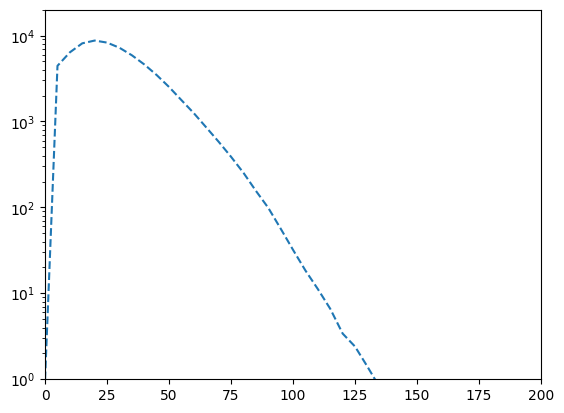

In [41]:
plt.plot(dates_chirps,total_rain_chirps,linestyle='dashed')
plt.yscale('log')
plt.ylim(1,20000)
plt.xlim(0,200)

902
421


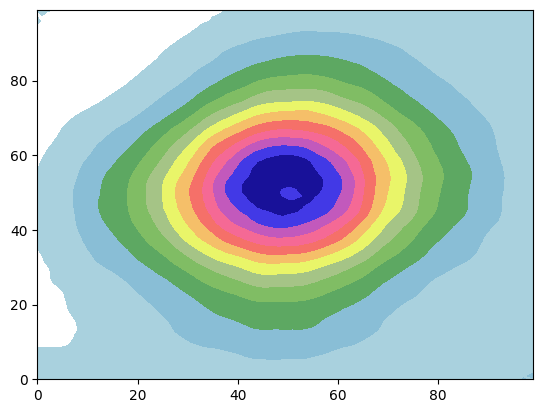

In [42]:
levels = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140]
plt.contourf(composite_nh,cmap=precip_cmap,levels=levels,extend='max')
print(nstorms_nh)
print(nstorms_sh)

In [ ]:
plt.plot(np.sum(data,axis=(1,2,3)))